## First Install Libraries and Load the Data 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from palmerpenguins import load_penguins

In [3]:
penguins_data = load_penguins()
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


## Cleaning the Data

We can remove the missing values.

In [4]:
# ---- In real life, save your raw data before you clean data! ----

# Ensuring a hard copy of the data is made. Sometimes you will encounter errors with soft copying in Python. 
penguins_clean = penguins_data.copy()

# Drop rows with missing values
penguins_clean = penguins_clean.dropna()





## Species

Lets first look at the data using a pairplot and colouring the points using their species. 

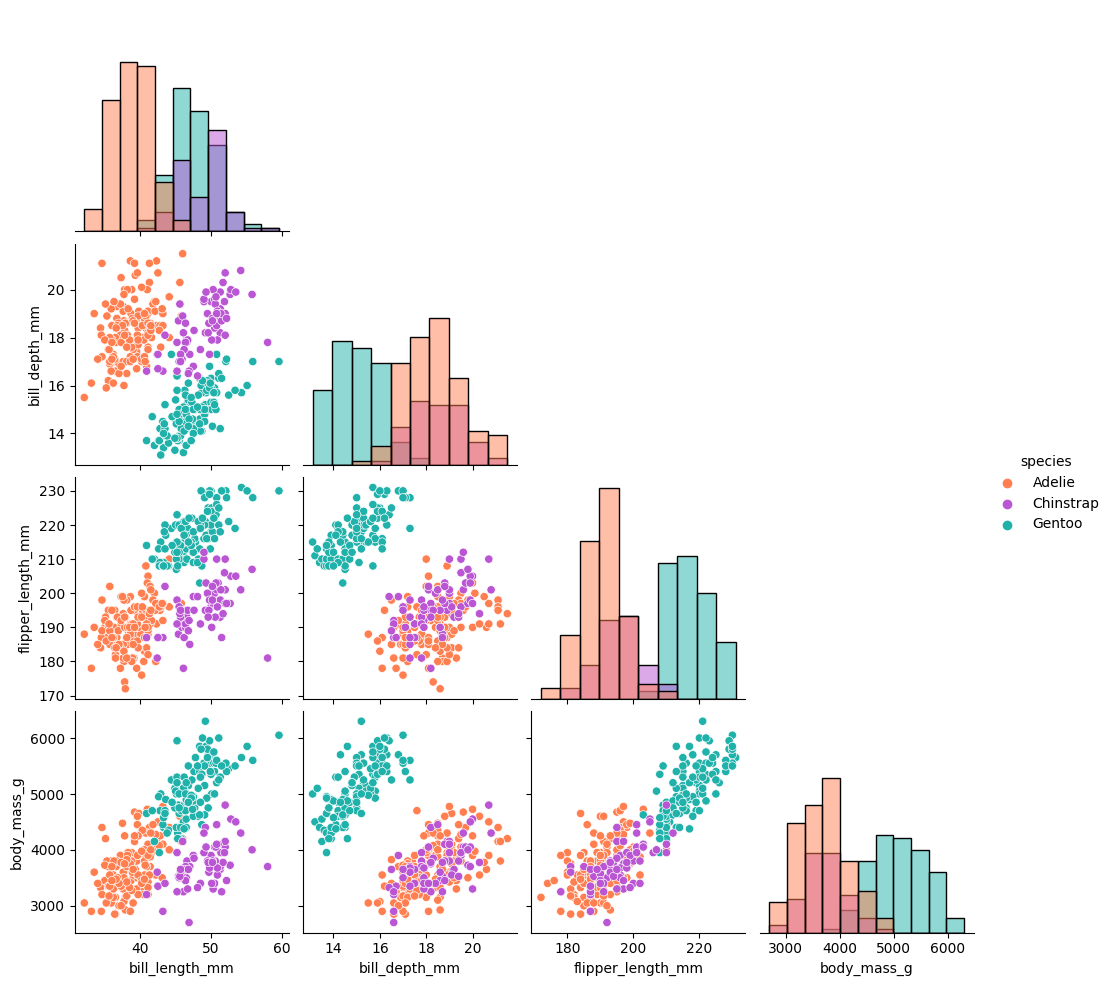

In [5]:
# The data in these columns are categorical. 
penguins_clean["species"] = penguins_clean["species"].astype("category")
penguins_clean["year"] = penguins_clean["year"].astype("category")


# I can make a dictionary to give the penguin species different colours.
colour_dict = {"Adelie"    :  "coral", 
               "Gentoo"    :  "lightseagreen", 
               "Chinstrap" :  "mediumorchid"}


# This plot will show us all the data plotted against each other. It will take a few seconds to generate. 
figure = sns.pairplot(penguins_clean, hue="species", diag_kind="hist", corner=True, palette=colour_dict)




This dataset has the species information, but we may want to see if we can cluster the data into species without that prior information from the researchers. 


In [8]:
# First we determine what goes into the model.
penguins_input = pd.DataFrame([penguins_clean.bill_length_mm, 
                               penguins_clean.bill_depth_mm]).transpose()
penguins_input.head()



,bill_length_mm,bill_depth_mm
0,39.1,18.7
1,39.5,17.4
2,40.3,18.0
4,36.7,19.3
5,39.3,20.6


In [9]:

model = KMeans(n_clusters=3, init='random', max_iter=100, random_state=101)
model.fit(penguins_input)

penguins_clean["labels"] = model.labels_
penguins_clean["labels"]

0      2
1      2
2      2
4      2
5      2
      ..
339    1
340    0
341    1
342    1
343    1
Name: labels, Length: 333, dtype: int32

These are guesses from the model about what 3 clusters of data exist. 

We can compare it with a side by side plot:

The accuracy for Adelie is 92.5 %
The accuracy for Gentoo is 62.2 %
The accuracy for Chinstrap is 58.8 %


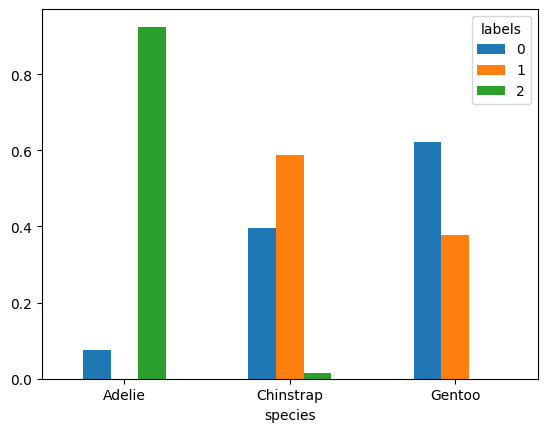

In [10]:
compare_labels = pd.crosstab(penguins_clean["species"], penguins_clean["labels"],normalize='index')


 # We can make a barplot to compare the labels to the species.
compare_labels.plot.bar(rot=0)

compare_labels = compare_labels.transpose()
compare_labels

species_list = penguins_clean["species"].unique()

for species in species_list:
    accuracy = compare_labels[species].max()
    accuracy = round(accuracy,3) *100
    print(f"The accuracy for {species} is {accuracy} %")






## Making Functions

A recap from your Python Lessons!

In [43]:

def create_input(data, columns):
    input_data = data[columns]
    return input_data

def kmean_clusters(data, n_clusters):
    model = KMeans(n_clusters=n_clusters, init='random', max_iter=100, random_state=101)
    model.fit(data)
    return model

def create_labels(data, model):
    data["labels"] = model.labels_
    return data

def make_confusion_matrix(prediction, actual):
    confusion_matrix = pd.crosstab(prediction, actual, normalize='index')
    return confusion_matrix

def print_accuracy(prediction, actual):
    confusion_matrix = make_confusion_matrix(prediction, actual)

    species_list = actual.unique()

    for species in species_list:
        accuracy = confusion_matrix[species].max()
        accuracy = round(accuracy *100,1)
        print(f"The accuracy for {species} is {accuracy} %")
    print("")
        
def plot_confusion_matrix(prediction, actual):
    confusion_matrix = make_confusion_matrix(prediction, actual)
    confusion_matrix.plot.bar(rot=0)

def run_k_means(data, columns, n_clusters):

    print(f"Using: {columns} to find {n_clusters} clusters.")

    input_data = create_input(data, columns)
    model = kmean_clusters(input_data, n_clusters)
    data = create_labels(data, model)
    
    print_accuracy(data["labels"], data["species"])
    
    return model




Now we can run this several times without copying and pasting actual code.

In [44]:
run_k_means(penguins_clean, ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"], 3)
run_k_means(penguins_clean, ["bill_length_mm", "flipper_length_mm"], 3)
run_k_means(penguins_clean, ["bill_depth_mm", "flipper_length_mm"], 3)
run_k_means(penguins_clean, ["bill_length_mm"], 3)


Using: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 92.2 %
The accuracy for Gentoo is 94.4 %
The accuracy for Chinstrap is 58.1 %

Using: ['bill_length_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 92.2 %
The accuracy for Gentoo is 94.4 %
The accuracy for Chinstrap is 58.1 %

Using: ['bill_depth_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 83.3 %
The accuracy for Gentoo is 95.2 %
The accuracy for Chinstrap is 45.5 %

Using: ['bill_length_mm'] to find 3 clusters.
The accuracy for Adelie is 98.5 %
The accuracy for Gentoo is 59.6 %
The accuracy for Chinstrap is 43.6 %



KMeans(init='random', max_iter=100, n_clusters=3, random_state=101)

## Improving the results

We can try to standardise the data to improve the results. This can help, but not always!

In [29]:
# Standardising the data

# Make a copy of the clean data. 
penguins_scaled = penguins_clean.copy()

# Only want to scale the continuous variables
column_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm","body_mass_g"]

scaler = StandardScaler()
penguins_scaled[column_names] = scaler.fit_transform(penguins_scaled[column_names])

penguins_scaled.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,labels
0,Adelie,Torgersen,-0.896042,0.780732,-1.426752,-0.568475,male,2007,2
1,Adelie,Torgersen,-0.822788,0.119584,-1.069474,-0.506286,female,2007,2
2,Adelie,Torgersen,-0.676280,0.424729,-0.426373,-1.190361,female,2007,2
4,Adelie,Torgersen,-1.335566,1.085877,-0.569284,-0.941606,female,2007,2
5,Adelie,Torgersen,-0.859415,1.747026,-0.783651,-0.692852,male,2007,2


In [33]:

# Remove any nans
penguins_scaled = penguins_scaled.dropna()

print("Using unscaled data:")
run_k_means(penguins_clean, ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"], 3)
run_k_means(penguins_clean, ["bill_length_mm", "body_mass_g"], 3)


print("Using scaled data:")
run_k_means(penguins_scaled, ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"], 3)
run_k_means(penguins_scaled, ["bill_length_mm", "body_mass_g"], 3)



Using unscaled data:
Using: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 92.2 %
The accuracy for Gentoo is 94.4 %
The accuracy for Chinstrap is 58.1 %

Using: ['bill_length_mm', 'body_mass_g'] to find 3 clusters.
The accuracy for Adelie is 67.1 %
The accuracy for Gentoo is 100.0 %
The accuracy for Chinstrap is 32.3 %

Using scaled data:
Using: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 96.6 %
The accuracy for Gentoo is 100.0 %
The accuracy for Chinstrap is 92.6 %

Using: ['bill_length_mm', 'body_mass_g'] to find 3 clusters.
The accuracy for Adelie is 93.9 %
The accuracy for Gentoo is 96.2 %
The accuracy for Chinstrap is 77.2 %



# Plotting the Clusters



Using: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'] to find 3 clusters.
The accuracy for Adelie is 96.6 %
The accuracy for Gentoo is 100.0 %
The accuracy for Chinstrap is 92.6 %



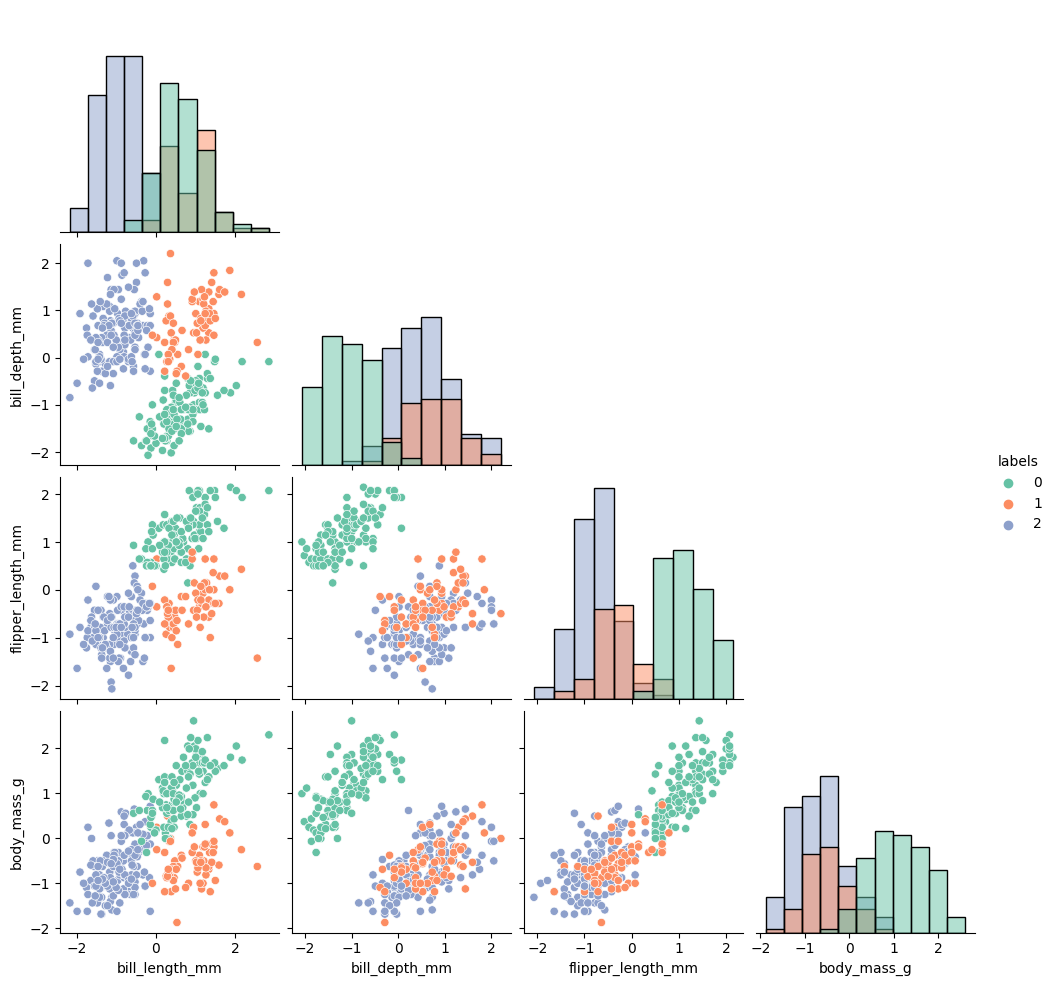

In [45]:
# We can plot the clusters to see how they look.

model = run_k_means(penguins_scaled, ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"], 3)

penguins_scaled["labels"] = model.labels_

figure = sns.pairplot(penguins_scaled, hue="labels", diag_kind="hist", corner=True, palette="Set2")

Text(0.5, 1.0, 'Clusters')

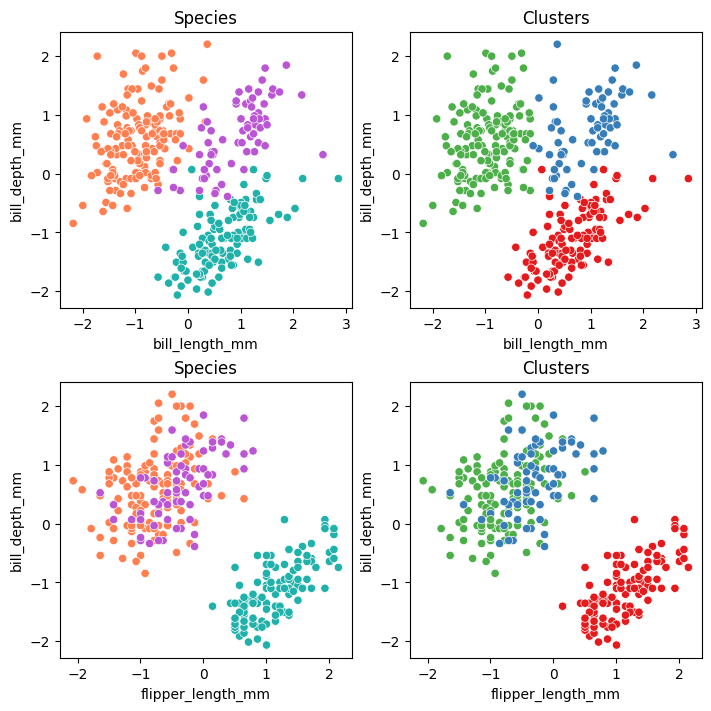

In [63]:
# We can compare these side by side with the original data.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(7,7), constrained_layout=True)

sns.scatterplot(data=penguins_scaled, x="bill_length_mm", y="bill_depth_mm", hue="species", ax=ax[0,0], palette=colour_dict, legend=False)
ax[0,0].set_title("Species")

sns.scatterplot(data=penguins_scaled, x="bill_length_mm", y="bill_depth_mm", hue="labels", ax=ax[0,1], palette="Set1", legend=False)
ax[0,1].set_title("Clusters")

sns.scatterplot(data=penguins_scaled, x="flipper_length_mm", y="bill_depth_mm", hue="species", ax=ax[1,0], palette=colour_dict, legend=False)
ax[1,0].set_title("Species")

sns.scatterplot(data=penguins_scaled, x="flipper_length_mm", y="bill_depth_mm", hue="labels", ax=ax[1,1], palette="Set1", legend=False)
ax[1,1].set_title("Clusters")


